In [1]:
slash= "\\"
import sys
# PathTomylibs-python= '/Users/s4356803/Documents/PhD/Codes/PythonCode/'
# PathToMyLibs= '/Users/s4356803/Documents/PhD/Codes/PythonCode/MyLibs-python'
PathToMyLibs= 'E:\\uqDDahl'

sys.path.append(PathToMyLibs)

import PyCapture2
import matplotlib.pyplot as plt
import numpy as np
import cv2
import multiprocessing
import time
import copy

#%from ctypes import*
import ctypes
from scipy import io, integrate, linalg, signal
import digiholoHeader as digH_hpy # as in header file for python... pretty clever I know (Daniel 2 seconds after writing this commment. Head slap you are a idiot )
import digholoCombinedFunction as mydigholoFunc

# Below is some extra libs that are useful
import os
import scipy.io
import math
# from scipy.io import savemat loadmat
# import ipywidgets
# import ComplexPlotFunction as cmplxplt
# import AnalysisFuncitons as ProCouplMat
# Global Ploting properties and style
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = [15,15]

import MyPythonLibs.OpticalOperators as OpticOp
import MyPythonLibs.ComplexPlotFunction as cmplxplt
import MyPythonLibs.GaussianBeamBasis as GaussBeams
import MyPythonLibs.GeneralFunctions as GenFuncs
import MyPythonLibs.AnalysisFuncitons as ProCouplMat
import MyPythonLibs.CoupMatrixAndMetricAnalysisFuncitons as MetricCals
import MyPythonLibs.SaveMaskToBinFile as SaveMaskBin
import MyPythonLibs.ModelabProcessBatchFile as Modelab
import MyPythonLibs.QuantumGateGenerator as QGateGen


In [2]:
%load_ext autoreload
%aimport  digiholoWindowForm
%autoreload 1

In [6]:
handleIdx=digH_hpy.digHolo.digHoloCreate()

In [ ]:
bus = PyCapture2.BusManager()
# Get the number of connected cameras
num_cams = bus.getNumOfCameras()
print(f"Number of cameras detected: {num_cams}")
if num_cams == 0:
    print("No cameras found.")
    # return

# Connect to the first camera
#If you had multiple cameras you would need to have a for loop here and connect to each of them.
camera = PyCapture2.Camera()
camera.connect(bus.getCameraFromIndex(0))

# Start capturing images
camera.startCapture()

In [15]:
#Try to get a frame until you have one
success = False
while not success:
    try:
        image = camera.retrieveBuffer()
        success = True
    except PyCapture2.Fc2error as e:
        print("Error capturing frame:", e)


#Convert the image acquired by the camera to be a np array and make a pointer for digiholo
frameBuffer_int = np.array(image.getData())
# frameBuffer_int = frameBuffer_int.reshape((image.getRows(), image.getCols(), image.getDataSize() // (image.getRows() * image.getCols())))
frameBuffer_int = frameBuffer_int.reshape((image.getRows(), image.getCols()))

# frameBuffer_int=np.squeeze(frameBuffer_int)
frameBuffer=frameBuffer_int.astype(np.float32)
frameBufferPtr = frameBuffer.ctypes.data_as(ctypes.POINTER(ctypes.c_float))
# plt.figure()
# plt.imshow(frameBuffer)

In [16]:
pixelSize = 3.75e-6
#Centre wavelength (nanometres)
lambda0 = 1550e-9
#Amount of detail to print to console. 0: Console off. 1: Basic info. 2:Debug mode. 3: You've got serious issues
verbosity = 2
#Sets the resolution mode of the reconstructed field.
#0 : Full resolution. Reconstructed field will have same pixel
#size/dimensions as the FFT window.
#1 : Low resolution. Reconstructed field will have dimension of the IFFT
#window. 
resolutionMode = 0
#Redirects stdout console to file.
consoleRedirectToFile = 1
consoleFilename = "digHoloConsole.txt"

#Viewport mode
# viewportMode = 1 #1 = Camera view.

#Number of camera framesb
frameCount = ((ctypes.c_int))()
batchCount = ((ctypes.c_int))()
polCount = ((ctypes.c_int))()
frameCount = 1
batchCount = frameCount
polCount = 1

# Get reconstructed fields
#The x/y axis of the field. Corresponding with the dimension in the camera
#plane.
# xPtr = (ctypes.POINTER(ctypes.c_float))()
# yPtr = (ctypes.POINTER(ctypes.c_float))()
# #The width/height of the x and y axes respectively.
# w = ((ctypes.c_int))()
# h =((ctypes.c_int))()

#Width/height of camera frames
CamDims=frameBuffer.shape
frameWidth = CamDims[1]
frameHeight = CamDims[0]
nx = frameWidth
ny = frameHeight

#Specifies the number of HG mode groups to decompose the beams in.
#Total modes = sum(1:maxMG). maxMG=1->1 mode, maxMG=9->45 modes.
maxMG = 1
InitalRun=True
if (InitalRun):
# if (InitalRun ):

    #Redirect the console to file if desired. Useful when using the dll where
    #not console is visible
    if consoleRedirectToFile:
        digH_hpy.digHolo.digHoloConfigSetVerbosity(handleIdx,verbosity)
        charPtr = ctypes.c_char_p(consoleFilename.encode('utf-8'))
        digH_hpy.digHolo.digHoloConsoleRedirectToFile(charPtr)

    #Set the basic properties of the off-axis digitial holography process.
    #See digHolo.h for additional properties. Look for ConfigSet/ConfigGet
    digH_hpy.digHolo.digHoloConfigSetFramePixelSize(handleIdx,pixelSize)
    digH_hpy.digHolo.digHoloConfigSetFrameDimensions(handleIdx,frameWidth,frameHeight);
    digH_hpy.digHolo.digHoloConfigSetWavelengthCentre(handleIdx,lambda0)

    digH_hpy.digHolo.digHoloConfigSetPolCount(handleIdx,polCount);
    digH_hpy.digHolo.digHoloConfigSetfftWindowSizeX(handleIdx,nx)
    digH_hpy.digHolo.digHoloConfigSetfftWindowSizeY(handleIdx,ny)
    digH_hpy.digHolo.digHoloConfigSetIFFTResolutionMode(handleIdx,resolutionMode)
    #Specifies the number of HG mode groups to decompose the beams with
    digH_hpy.digHolo.digHoloConfigSetBasisGroupCount(handleIdx,maxMG)

    #Defines which parameters to optimise in the AutoAlign routine. These are on by default anyways
    digH_hpy.digHolo.digHoloConfigSetAutoAlignBeamCentre(handleIdx,1)
    digH_hpy.digHolo.digHoloConfigSetAutoAlignDefocus(handleIdx,1)
    digH_hpy.digHolo.digHoloConfigSetAutoAlignTilt(handleIdx,1)
    digH_hpy.digHolo.digHoloConfigSetAutoAlignBasisWaist(handleIdx,1)

    # Lets not do a auto align on the WindowRadius
    digH_hpy.digHolo.digHoloConfigSetAutoAlignFourierWindowRadius(handleIdx,0);
    #We are going to set the WindowRadius manually
    digH_hpy.digHolo.digHoloConfigSetFourierWindowRadius(handleIdx,0.2)
    # FFTRadius=digH_hpy.digHolo.digHoloConfigGetFourierWindowRadius(handleIdx)

    #Setup a batch of batchCount frames, starting at the frameBufferPtr
    digH_hpy.digHolo.digHoloSetBatch(handleIdx,batchCount,frameBufferPtr)
    digH_hpy.digHolo.digHoloAutoAlign(handleIdx)
    InitalRun=False
        
mydigholoFunc.updateFields_FFT(handleIdx,batchCount,frameBufferPtr)
Fullimage,cam_rgb=mydigholoFunc.GetViewport_arr(handleIdx,frameBuffer)
# plt.imshow(Fullimage)
# windowName='digholoviewport'
# # Create a resizable window
# cv2.namedWindow(windowName, cv2.WINDOW_NORMAL)
# # Set the window to full screen (optional)
# # cv2.setWindowProperty('Resizable Window', cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)
# # Resize the window to your desired size (width, height)
# cv2.resizeWindow(windowName, 800, 600)  # Change the width and height as needed
# Fullimage_rgb = cv2.cvtColor(Fullimage, cv2.COLOR_BGR2RGB)# this is to get the correct colour for opencv matplotlib doesnt have this problem
# cv2.imshow(windowName, Fullimage_rgb)
# cv2.imshow("Camera Image", frameBuffer_int)
# cv2.imshow("Camera digiholo", cam_rgb)

     




1


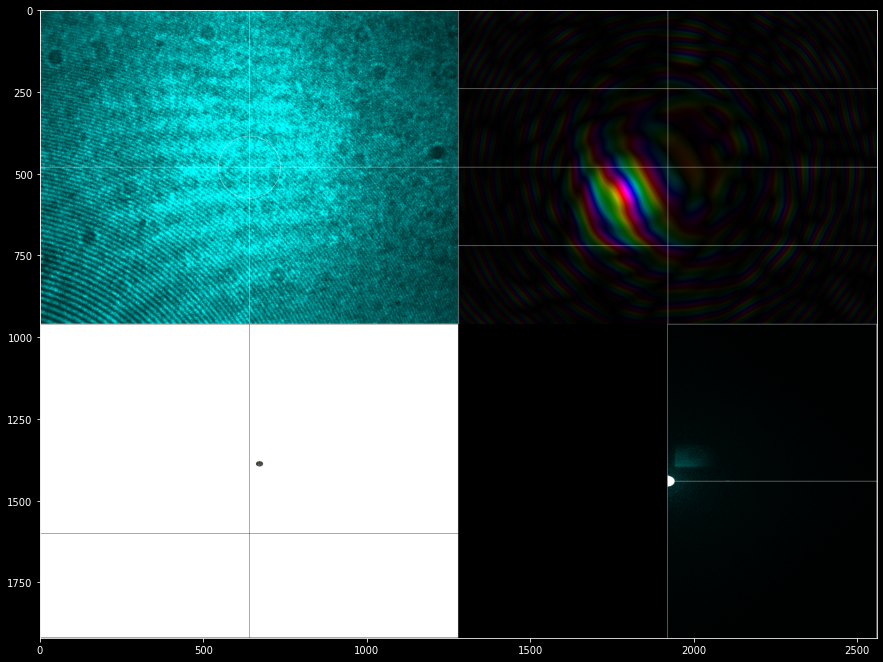

In [17]:
plt.figure()
plt.imshow(Fullimage)


# kill the camera

In [ ]:

    camera.stopCapture()
    camera.disconnect()